In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from tqdm import tqdm
from scipy.stats import pearsonr
from collections import defaultdict
import gseapy as gp
import anndata
import pandas as pd
from scipy import stats
from eval_utils import *
# from plot_utils import *
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import decimal_to_percent
from plottable.plots import bar, percentile_bars, percentile_stars, progress_donut
import matplotlib
import os

sns.set_style('whitegrid')

In [3]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'
datasets = ['Adamson2016', 'Norman2019',
            'ReplogleK562_gwps', 'ReplogleRPE1_v2',
            'TianCRISPRa2021', 'TianCRISPRi2021',
            'XuKinetics2024',
            'FrangiehControlSingle2021', 'FrangiehCocultureSingle2021', 'FrangiehIfnSingle2021'
           ]
dataset_names = ['adamson2016', 'norman2019', 
                 'replogle_k562_gwps_2022', 'replogle_rpe1_v2_2022',
                 'tian_CRISPRa_2021_scperturb', 'tian_CRISPRi_2021_scperturb',
                 'xu_kinetics_2024',
                 'frangieh_control_single_2021', 'frangieh_coculture_single_2021', 'frangieh_ifn_single_2021']
dataset_labels = ['Adamson', 'Norman',
                  'Replogle\n(K562)', 'Replogle\n(RPE1)',
                  'Tian\n(CRISPRa)', 'Tian\n(CRISPRi)',
                  'Xu',
                  'Frangieh\n(Control)', 'Frangieh\n(Co-culture)', 'Frangieh\n(IFN)'
                 ]
dataset_dict = {k: v for k, v in zip(dataset_names, datasets)}
dataset_label_dict = {k: v for k, v in zip(dataset_names, dataset_labels)}
dataset_map = {k: v for k, v in zip(datasets, dataset_labels)}

seeds = [1, 2, 3]
methods = ['cpa', 'gears', 'scgpt', 'scgpt_ft', 'nonctl-mean', 'matching-mean']

In [ ]:
results_df = pd.DataFrame(
    columns=["dataset", "method", "pert", "seed", "corr_all", "corr_20de",
             "corr_all_allpert", "corr_20de_allpert",
             "mse_all", "mse_20de", "mse_all_allpert", "mse_20de_allpert",
             "jaccard", "jaccard_allpert", "one gene", "train"]
)
avg_pert_centroids = 'centroids'
for dataset, dataset_name in zip(datasets, dataset_names):
    for seed in seeds:
        file = f'../data/{dataset_name}/{dataset_name}_{seed}.h5ad'
        adata = anndata.read_h5ad(file)
        print(dataset, len(adata.obs['condition'].unique()))
        
        # Get control mean, non control mean (pert_mean), and non control mean differential
        train_adata = adata[adata.obs['split'] == 'train']
        control_adata = train_adata[train_adata.obs['control'] == 1]
        pert_adata = train_adata[train_adata.obs['control'] == 0]

        if 'Frangieh' in dataset:
            control_mean = np.array(adata[adata.obs['sgRNAs'].str.contains('_SITE_')].X.mean(axis=0))[0]
        else:
            control_mean = np.array(control_adata.X.mean(axis=0))[0]
        if avg_pert_centroids == 'centroids':
            pert_mean = average_of_perturbation_centroids(pert_adata)
        else:
            pert_mean = np.array(pert_adata.X.mean(axis=0))[0]
        
        for method in tqdm(methods):
            p = f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv'
            if not os.path.exists(p):
                print('Predictions not ready for method: ', method, 'dataset: ', dataset, 'seed: ', seed)
                continue
            post_gt_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-gt.csv', index_col=[0, 1])
            post_pred_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv', index_col=[0, 1])
            conditions = post_gt_df.index.get_level_values('condition').unique()
            for condition in conditions:
                gene_list = condition.split("+")
                one_gene = False
                if "ctrl" in gene_list:
                    gene_list.remove("ctrl")
                    one_gene = True
                one_gene_str = "1-gene" if one_gene else "2-gene"
    
                # Get data
                X_true = post_gt_df.loc[condition].values[0]
                X_pred = post_pred_df.loc[condition].values[0]
                delta_true = X_true - control_mean
                delta_pred = X_pred - control_mean

                delta_true_allpert = X_true - pert_mean
                delta_pred_allpert = X_pred - pert_mean
                n_train = post_gt_df.loc[condition].index.get_level_values('n_train').values[0]

                # Get top 20 DE genes
                adata_condition = adata[adata.obs["condition"] == condition]

                # Select top 20 DE genes
                top20_de_genes = adata.uns["top_non_dropout_de_20"][
                    adata_condition.obs["condition_name"].values[0]
                ]
                top20_de_idxs = np.argwhere(
                    np.isin(adata.var.index, top20_de_genes)
                ).ravel()

                top20_de_idxs_pred = get_topk_de_gene_ids(control_mean, X_pred, k=20)

                # Store results
                results_df.loc[len(results_df)] = [
                    dataset,
                    method,
                    condition,
                    seed,
                    pearsonr(delta_true, delta_pred)[0],
                    pearsonr(delta_true[top20_de_idxs], delta_pred[top20_de_idxs])[0],
                    pearsonr(delta_true_allpert, delta_pred_allpert)[0],
                    pearsonr(delta_true_allpert[top20_de_idxs], delta_pred_allpert[top20_de_idxs])[0],
                    np.mean((delta_true - delta_pred)**2),
                    np.mean((delta_true[top20_de_idxs] - delta_pred[top20_de_idxs])**2),
                    np.mean((delta_true_allpert - delta_pred_allpert)**2),  # NOTE: This metric is independent of the reference
                    np.mean((delta_true_allpert[top20_de_idxs] - delta_pred_allpert[top20_de_idxs])**2),  # NOTE: This metric is independent of the reference
                    jaccard_similarity(top20_de_idxs, top20_de_idxs_pred),
                    np.nan, # jaccard_similarity(top20_de_idxs_allpert, top20_de_idxs_pred_allpert),
                    one_gene_str,
                    n_train,
                ]

In [ ]:
# Calculate RMSE
results_df['rmse_all'] = np.sqrt(results_df['mse_all'])
results_df['rmse_20de'] = np.sqrt(results_df['mse_20de'])
results_df['rmse_all_allpert'] = np.sqrt(results_df['mse_all_allpert'])
results_df['rmse_20de_allpert'] = np.sqrt(results_df['mse_20de_allpert'])

In [4]:
# Store results
# results_df.to_csv(f'{outdir}/all_results_20250414.csv')
results_df = pd.read_csv(f'{outdir}/all_results_20250414.csv', index_col=0)

#### Degree of systematic variation per dataset

In [ ]:
seed = 1
dfs = []
dfs_pair = []
dfs_norm = []
for dataset_name in tqdm(dataset_names):
    file = f'../data/{dataset_name}/{dataset_name}_{seed}.h5ad'
    adata = anndata.read_h5ad(file)
    control_mean = None
    if 'frangieh' in dataset_name:  # Use 2 types of control (non targeting and intergenic target)
        control_mean = np.array(adata[adata.obs['sgRNAs'].str.contains('_SITE_')].X.mean(axis=0))[0]  
    df, df_pair, df_norm, pert_names = compute_shift_similarities(adata, control_mean=control_mean)
    print(len(df))
    df['dataset'] = dataset_name
    df_pair['dataset'] = dataset_name
    df_norm['dataset'] = dataset_name
    dfs.append(df)
    dfs_pair.append(df_pair)
    dfs_norm.append(df_norm)
dfs = pd.concat(dfs)
dfs_pair = pd.concat(dfs_pair)
dfs_norm = pd.concat(dfs_norm)

In [5]:
# dfs.to_csv(f'{outdir}/all_dfs_20250414.csv')
# dfs_pair.to_csv(f'{outdir}/all_dfs_pair_20250414.csv')
# dfs_norm.to_csv(f'{outdir}/all_dfs_norm_20250414.csv')
dfs = pd.read_csv(f'{outdir}/all_dfs_20250414.csv')
# dfs_pair = pd.read_csv(f'{outdir}/all_dfs_pair_20250414.csv')
# dfs_norm = pd.read_csv(f'{outdir}/all_dfs_norm_20250414.csv')

In [6]:
grouped_vals_ = dfs[dfs['variable'] == 'avg_ctl'].groupby('dataset')['value']
x_ = grouped_vals_.mean().loc[dataset_names]
x_std_ = grouped_vals_.std().loc[dataset_names]
x_count_ = grouped_vals_.count().loc[dataset_names]
x_stderr_ = x_std_ / np.sqrt(x_count_)
idxs_ = np.argsort(x_.values)

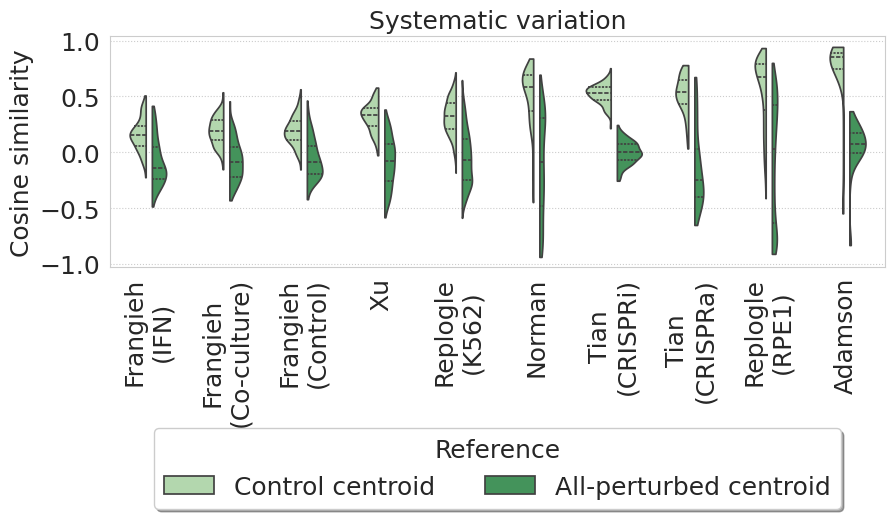

In [7]:
fontsize=18

plt.figure(figsize=(10, 3))
order = x_.iloc[idxs_].index
order = [d for d in order if d != 'replogle_k562_v2_2022']
sns.violinplot(data=dfs[dfs['dataset'] != 'replogle_k562_v2_2022'],
               x='dataset',
               y='value',
               order=order,
               hue='variable',
               split=True,
               inner="quart",
               gap=.2,
               ax=plt.gca(),
               palette="Greens",
               cut=0
              )
plt.legend([],[], frameon=False)
plt.title('Systematic variation', fontsize=fontsize)
plt.ylabel('Cosine similarity', fontsize=fontsize)
xticks = plt.gca().get_xticklabels()
mapped_labels = [dataset_label_dict.get(label.get_text(), label.get_text()) for label in plt.gca().get_xticklabels()]
plt.xticks(np.arange(len(mapped_labels)), mapped_labels, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('')
plt.xticks(rotation=90);
plt.grid(axis='y', linestyle='dotted')
# Legend
handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.legend(handles,
                    labels,
                    title='Reference',
                    loc='lower center',
                    bbox_to_anchor=(0.5, -1.1),
                    fancybox=True,
                    shadow=True,
                    ncol=2,
                    title_fontsize=fontsize,
                    fontsize=fontsize
                    # title_fontproperties={'weight':'bold'}
                   )
labels=['Control centroid', 'All-perturbed centroid']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label);
    
plt.savefig(f'{figdir}/systematic_variation_violin.pdf', bbox_inches='tight');
plt.show()

In [11]:
avg_corrs = pd.DataFrame(results_df_2.groupby(['dataset', 'idx'])[metric].mean()).reset_index().sort_values('idx')[metric].values
sys_var = x[idxs].values
pearsonr(avg_corrs, sys_var)

/tmp/ipykernel_2854999/1979318981.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sys_var = x[idxs].values


PearsonRResult(statistic=0.9703220167273474, pvalue=3.2746442285582136e-06)

/tmp/ipykernel_2854999/1467874317.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x[idxs],
/tmp/ipykernel_2854999/1467874317.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_2['idx'] = results_df_2['dataset'].map({d: i for i, d in enumerate(ds)})
/tmp/ipykernel_2854999/1467874317.py:66: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  sns.lineplot(x="idx", y=metric,


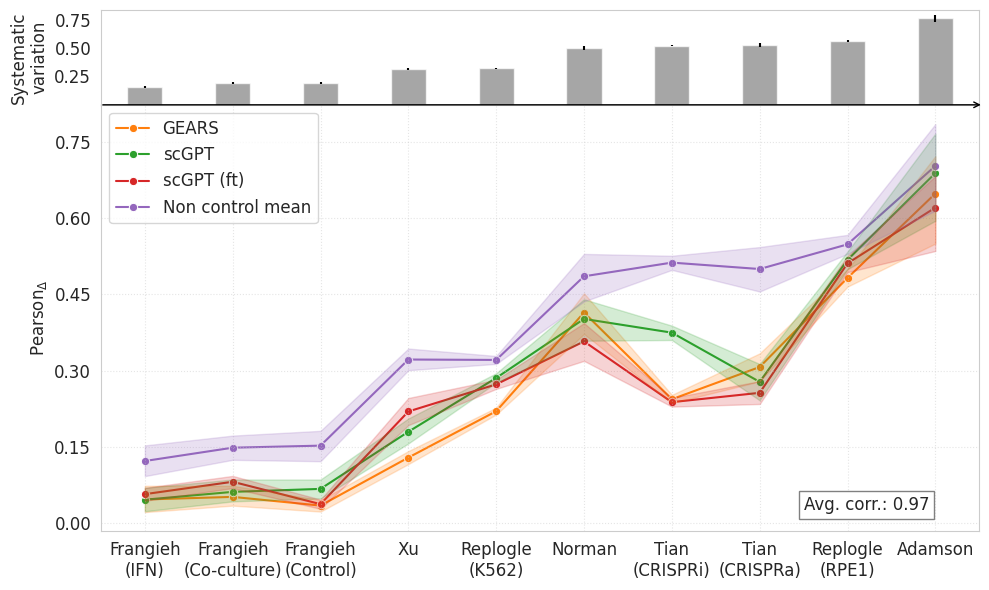

In [9]:
sns.set_style('whitegrid')
metric = 'corr_all'
fontsize=12
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [1, 4.5], 'hspace': 0.0})
# plt.subplots_adjust(hspace=0)
# plt.suptitle('Performance by degree of systematic variation')

# Metric to sort by
grouped_vals = dfs[dfs['variable'] == 'avg_ctl'].groupby('dataset')['value']
grouped_vals.mean(), grouped_vals.std()
x = grouped_vals.mean().loc[dataset_names]
x_std = grouped_vals.std().loc[dataset_names]
x_count = grouped_vals.count().loc[dataset_names]
x_stderr = x_std / np.sqrt(x_count)
idxs = np.argsort(x.values)
bar_width = 0.4  # Controls width of bars

ax[0].bar(np.arange(len(dataset_labels)), # - bar_width/2
          x[idxs],
          width=bar_width,
          yerr=x_stderr.iloc[idxs],
          color="gray",
          alpha=0.7)
ax[0].set_ylabel("Systematic\nvariation", fontsize=fontsize)  # , color="gray"
ax[0].set_yticks(np.arange(0.25, 0.8, 0.25))  # Adjust range if needed
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
ax[0].grid(False)

# Bottom plot (Pearson correlations)
ds = np.array(datasets)[idxs]
results_df_ = results_df[results_df['one gene'] == '1-gene']
results_df_2 = results_df_[~results_df_['method'].isin(['cpa', 'matching-mean'])]
results_df_2['idx'] = results_df_2['dataset'].map({d: i for i, d in enumerate(ds)})
palette = sns.color_palette("tab10")
sns.lineplot(x="idx", y=metric,
             hue="method", # errorbar=('ci', 95), # style="event",
             data=results_df_2,
             marker='o',
             palette=palette[1:],
             ax = ax[1],
             zorder=0
            )
plt.xticks(np.arange(len(dataset_labels)), np.array(dataset_labels)[idxs], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax[1].set_xlabel('');
ax[1].set_ylabel('Pearson$_\Delta$', fontsize=fontsize)
ax[1].set_yticks(np.arange(0, .79, 0.15))
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
legend = ax[1].legend(fontsize=fontsize)
labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)

# Arrow
ax[1].annotate(
    text="",  # No text, just an arrow
    xy=(1.005, 1.0),  # Arrowhead (right side, slightly above the x-axis)
    xytext=(-0.001, 1.0),  # Arrow start (left side)
    xycoords="axes fraction",  # Relative to the bottom subplot
    arrowprops=dict(arrowstyle="->", color="black", linewidth=1),
)

ax[1].annotate(
    text='Avg. corr.: 0.97',
    xy=(0.8, 0.05),
    xycoords="axes fraction",  # Relative to the bottom subplot
    fontsize=fontsize,
    bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="gray", lw=1)
)

# Formatting
ax[1].grid(True, linestyle="dotted", alpha=0.5)
ax[0].set_xlim(-0.5, len(x) - 0.5)  # Adjust to reduce padding
ax[1].set_xlim(-0.5, len(x) - 0.5)  # Adjust to reduce padding
plt.margins(x=0)
plt.tight_layout()
plt.savefig(f'{figdir}/{metric}_by_dataset_alignment_3.pdf', bbox_inches='tight');
plt.show()

/tmp/ipykernel_2854999/2077790833.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x[idxs],
/tmp/ipykernel_2854999/2077790833.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_2['idx'] = results_df_2['dataset'].map({d: i for i, d in enumerate(ds)})
/tmp/ipykernel_2854999/2077790833.py:66: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  sns.lineplot(x="idx", y=metric,


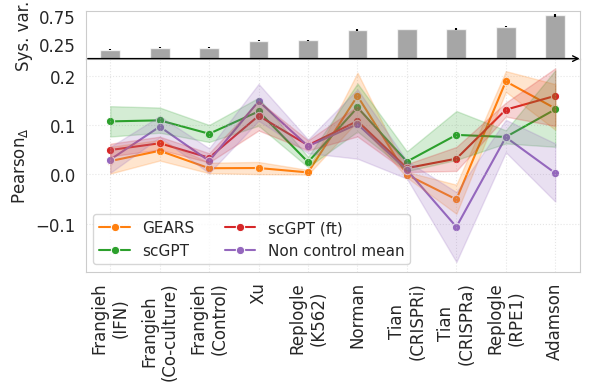

In [12]:
sns.set_style('whitegrid')
metric = 'corr_all_allpert'
fontsize=12
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [1, 4.5], 'hspace': 0.0})
# plt.subplots_adjust(hspace=0)
# plt.suptitle('Performance by degree of systematic variation')

# Metric to sort by
grouped_vals = dfs[dfs['variable'] == 'avg_ctl'].groupby('dataset')['value']
grouped_vals.mean(), grouped_vals.std()
x = grouped_vals.mean().loc[dataset_names]
x_std = grouped_vals.std().loc[dataset_names]
x_count = grouped_vals.count().loc[dataset_names]
x_stderr = x_std / np.sqrt(x_count)
idxs = np.argsort(x.values)
bar_width = 0.4  # Controls width of bars

ax[0].bar(np.arange(len(dataset_labels)), # - bar_width/2
          x[idxs],
          width=bar_width,
          yerr=x_stderr.iloc[idxs],
          color="gray",
          alpha=0.7)
ax[0].set_ylabel("Sys. var.", fontsize=fontsize)  # , color="gray"
ax[0].set_yticks(np.arange(0.25, 0.8, 0.5))  # Adjust range if needed
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
ax[0].grid(False)

# Bottom plot (Pearson correlations)
ds = np.array(datasets)[idxs]
results_df_ = results_df[results_df['one gene'] == '1-gene']
results_df_2 = results_df_[~results_df_['method'].isin(['cpa', 'matching-mean'])]
results_df_2['idx'] = results_df_2['dataset'].map({d: i for i, d in enumerate(ds)})
palette = sns.color_palette("tab10")
sns.lineplot(x="idx", y=metric,
             hue="method", # errorbar=('ci', 95), # style="event",
             data=results_df_2,
             marker='o',
             palette=palette[1:],
             ax = ax[1],
             zorder=0
            )
plt.xticks(np.arange(len(dataset_labels)), np.array(dataset_labels)[idxs], fontsize=fontsize-1, rotation=90)
plt.yticks(fontsize=fontsize)
ax[1].set_xlabel('');
ax[1].set_ylabel('Pearson$_\Delta$', fontsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
legend = ax[1].legend(fontsize=fontsize-1, ncol=2)
labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)

# Arrow
ax[1].annotate(
    text="",  # No text, just an arrow
    xy=(1.005, 1.0),  # Arrowhead (right side, slightly above the x-axis)
    xytext=(-0.001, 1.0),  # Arrow start (left side)
    xycoords="axes fraction",  # Relative to the bottom subplot
    arrowprops=dict(arrowstyle="->", color="black", linewidth=1),
)

# Formatting
ax[1].grid(True, linestyle="dotted", alpha=0.5)
ax[0].set_xlim(-0.5, len(x) - 0.5)  # Adjust to reduce padding
ax[1].set_xlim(-0.5, len(x) - 0.5)  # Adjust to reduce padding
plt.margins(x=0)
plt.tight_layout()
plt.savefig(f'{figdir}/{metric}_by_dataset_alignment_3.pdf', bbox_inches='tight');
plt.show()

In [ ]:
grouped_vals = dfs[dfs['variable'] == 'avg_ctl'].groupby('dataset')['value']
grouped_vals.mean(), grouped_vals.std()
x = grouped_vals.mean().loc[dataset_names]
idxs = np.argsort(x.values)
x[idxs]

In [ ]:
metric = 'corr_all'
method = 'gears'
v = results_df_2[results_df_2['method'] == method].groupby('dataset')[[metric, 'idx']].mean().sort_values('idx')[metric]
pearsonr(x[idxs], v)

/tmp/ipykernel_2854999/1644735841.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x[idxs],
/tmp/ipykernel_2854999/1644735841.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_2['idx'] = results_df_2['dataset'].map({d: i for i, d in enumerate(ds)})
/tmp/ipykernel_2854999/1644735841.py:66: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  sns.lineplot(x="idx", y=metric,


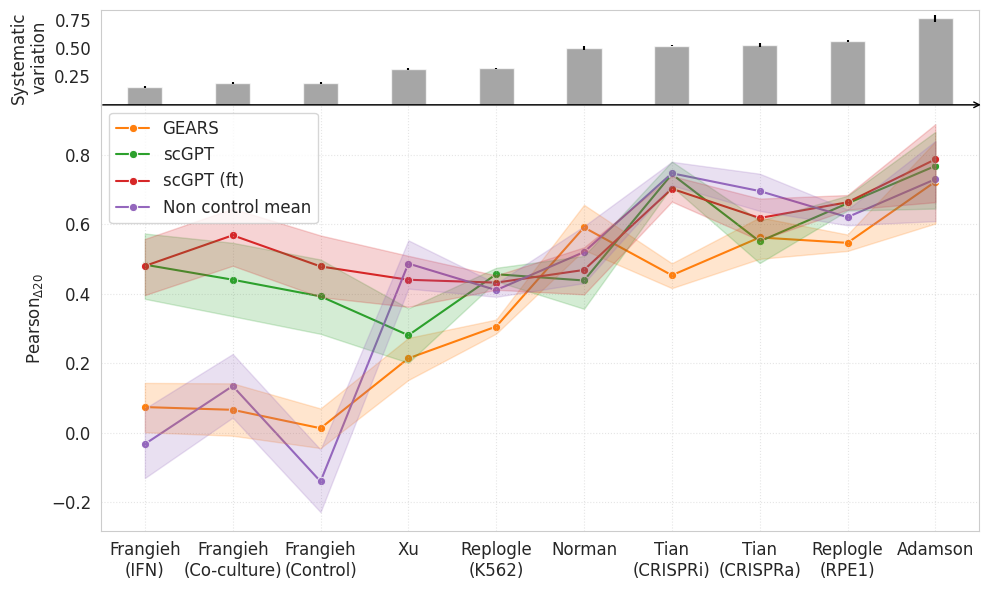

In [14]:
sns.set_style('whitegrid')
metric = 'corr_20de'
fontsize=12
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [1, 4.5], 'hspace': 0.0})

# Metric to sort by
grouped_vals = dfs[dfs['variable'] == 'avg_ctl'].groupby('dataset')['value']
grouped_vals.mean(), grouped_vals.std()
x = grouped_vals.mean().loc[dataset_names]
x_std = grouped_vals.std().loc[dataset_names]
x_count = grouped_vals.count().loc[dataset_names]
x_stderr = x_std / np.sqrt(x_count)
idxs = np.argsort(x.values)
bar_width = 0.4  # Controls width of bars

ax[0].bar(np.arange(len(dataset_labels)), # - bar_width/2
          x[idxs],
          width=bar_width,
          yerr=x_stderr.iloc[idxs],
          color="gray",
          alpha=0.7)
ax[0].set_ylabel("Systematic\nvariation", fontsize=fontsize)  # , color="gray"
ax[0].set_yticks(np.arange(0.25, 0.8, 0.25))  # Adjust range if needed
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
ax[0].grid(False)

# Bottom plot (Pearson correlations)
ds = np.array(datasets)[idxs]
results_df_ = results_df[results_df['one gene'] == '1-gene']
results_df_2 = results_df_[~results_df_['method'].isin(['cpa', 'matching-mean'])]
results_df_2['idx'] = results_df_2['dataset'].map({d: i for i, d in enumerate(ds)})
palette = sns.color_palette("tab10")
sns.lineplot(x="idx", y=metric,
             hue="method", # errorbar=('ci', 95), # style="event",
             data=results_df_2,
             marker='o',
             palette=palette[1:],
             ax = ax[1],
             zorder=0
            )
plt.xticks(np.arange(len(dataset_labels)), np.array(dataset_labels)[idxs], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax[1].set_xlabel('');
ax[1].set_ylabel('Pearson$_{\Delta20}$', fontsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
legend = ax[1].legend(fontsize=fontsize)
labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)

# Arrow
ax[1].annotate(
    text="",  # No text, just an arrow
    xy=(1.005, 1.0),  # Arrowhead (right side, slightly above the x-axis)
    xytext=(-0.001, 1.0),  # Arrow start (left side)
    xycoords="axes fraction",  # Relative to the bottom subplot
    arrowprops=dict(arrowstyle="->", color="black", linewidth=1),
)

# Formatting
ax[1].grid(True, linestyle="dotted", alpha=0.5)
ax[0].set_xlim(-0.5, len(x) - 0.5)  # Adjust to reduce padding
ax[1].set_xlim(-0.5, len(x) - 0.5)  # Adjust to reduce padding
plt.margins(x=0)
plt.tight_layout()
plt.savefig(f'{figdir}/{metric}_by_dataset_alignment_3.pdf', bbox_inches='tight');
plt.show()

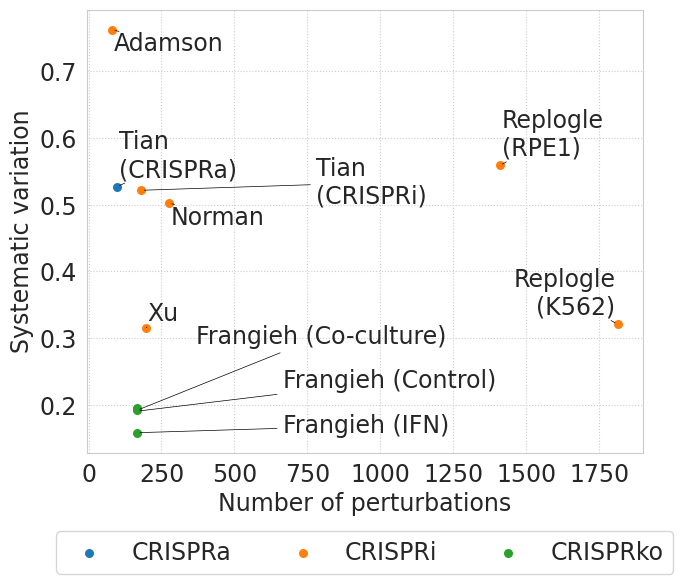

In [17]:
fontsize=17
sns.set_style('whitegrid')
techs = np.array(['CRISPRi', 'CRISPRi', 'CRISPRi', 'CRISPRi', 'CRISPRa', 'CRISPRi', 'CRISPRi', 'CRISPRko', 'CRISPRko', 'CRISPRko'])

# plt.scatter(x_count, x)
grouped_vals_ = dfs[dfs['variable'] == 'avg_ctl'].groupby('dataset')['value']
x_ = grouped_vals_.mean().loc[dataset_names]
x_std_ = grouped_vals_.std().loc[dataset_names]
x_count_ = grouped_vals_.count().loc[dataset_names]
x_stderr_ = x_std_ / np.sqrt(x_count_)

plt.figure(figsize=(7, 6))
ax = plt.gca()
# ax.errorbar(x_count, x, yerr=x_std, fmt='o', capsize=3, label="Data")
unique_techs = np.unique(techs)
for tech in unique_techs:
    m = tech == techs
    plt.scatter(x_count_[m], x_[m], label=tech, s=30)
# idxs = [datasets_.index(d) for d in np.array(datasets_)[idxs_]]
x_labels_ = [dataset_label_dict[d] for d in x_.index]
texts = []
target_x = []
target_y = []
for i, v in enumerate(x_labels_):
    if v == 'Frangieh\n(IFN)':
        ax.annotate('Frangieh (IFN)', xy=(x_count_.values[i], x_.values[i]), xytext=(x_count_.values[i]+500, x_.values[i]), fontsize=fontsize, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    elif v == 'Frangieh\n(Control)':
        ax.annotate('Frangieh (Control)', xy=(x_count_.values[i], x_.values[i]-0.005), xytext=(x_count_.values[i]+500, x_.values[i]+0.03), fontsize=fontsize, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    elif v == 'Frangieh\n(Co-culture)':
        ax.annotate('Frangieh (Co-culture)', xy=(x_count_.values[i], x_.values[i]), xytext=(x_count_.values[i]+200, x_.values[i]+0.1), fontsize=fontsize, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    elif v == 'Tian\n(CRISPRi)':
        ax.annotate(v, xy=(x_count_.values[i], x_.values[i]), xytext=(x_count_.values[i]+600, x_.values[i]-0.02), fontsize=fontsize, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    else:
        target_x.append(x_count_.values[i])
        target_y.append(x_.values[i])
        texts.append(ax.annotate(v, (x_count_.values[i], x_.values[i]), fontsize=fontsize))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5), x=target_x, y=target_y, force_text=1.375)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(linestyle='dotted')
plt.legend(fontsize=fontsize);
plt.xlabel('Number of perturbations', fontsize=fontsize)
plt.ylabel('Systematic variation', fontsize=fontsize);
legend = plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=False, ncol=3, fontsize=fontsize)
plt.tight_layout()
plt.savefig(f'{figdir}/systematic_variation_nperts.pdf', bbox_inches='tight');
plt.show()

In [ ]:
metric = 'corr_20de'
results_df_3 = results_df_2[results_df_2['dataset'] != 'ReplogleK562_v2']
df = pd.DataFrame(results_df_3.groupby(['dataset', 'method'])[metric].mean())
ordered_unique_datasets = np.unique(df.index.get_level_values(0))
dataset_idxs = [datasets_.index(d) for d in df.index.get_level_values(0)]
mapped_dataset_names = np.array(dataset_names_)[dataset_idxs]
df['Systematic variation'] = x.loc[mapped_dataset_names].values
df = df.reset_index()
x_ = df[df['method'] == 'gears']['Systematic variation'].values
y_ = df[df['method'] == 'gears'][metric].values
plt.scatter(x_, y_)

#### Dotplot figure

In [20]:
def custom_cmap(values, descending=True):
    mx = np.max(values)
    mn = np.min(values)
    if descending:
        mx = np.min(values)
        mn = np.max(values)
        
    def get_color(x):
        sign = 1 if int(descending) else -1
        idx = sign*2
        # print(np.partition(values, -2)[idx])
        x_sorted = np.sort(values)
        if descending:
            x_sorted = x_sorted[::-1]
        if np.allclose(x, mx):
            return "#46a64e"
        elif x == x_sorted[idx]: # np.partition(values, -2)[idx]:
            return "#c9ecb4"
        return "#ffffff"
    return get_color     

/tmp/ipykernel_2854999/2641685315.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_['method'] = results_df_['method'].replace(method_names)
/tmp/ipykernel_2854999/2641685315.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_['dataset'] = results_df_['dataset'].map(dataset_map)


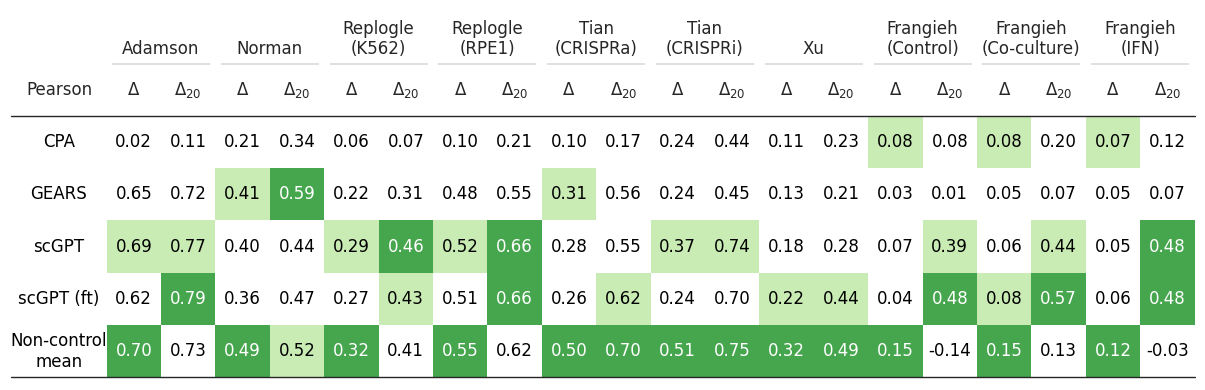

In [26]:
fontsize=12

method_names = {
    'cpa': 'CPA',
    'gears': 'GEARS',
    'scgpt': 'scGPT',
    'scgpt_ft': 'scGPT (ft)',
    'nonctl-mean': 'Non-control\nmean',
}

metric_names = {
    'corr_all': '$\Delta$',
    'corr_20de': '${\Delta_{20}}$',
}
dataset_map = {k: v for k, v in zip(datasets, dataset_labels)}

results_df_ = results_df[results_df['one gene'] == '1-gene']
results_df_['method'] = results_df_['method'].replace(method_names)
results_df_['dataset'] = results_df_['dataset'].map(dataset_map)
df = results_df_[['dataset', 'method'] + list(metric_names.keys())].groupby(['dataset', 'method']).mean()
df = df.round(2)
df_ = df.unstack(level=0).swaplevel(1, 0, axis=1).loc[method_names.values()]

col_defs = [
        ColumnDefinition(
            name="method",
            title="Pearson",
            textprops={"ha": "center", "fontsize": fontsize},  # "weight": "bold"
            width=1.75,
        ),
    ]

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

cols_order = []
for d in dataset_labels:
    for m, m_name in metric_names.items():
        cmap_name = matplotlib.cm.PiYG
        if '↓' in m_name:
            cmap_name = matplotlib.cm.PiYG_r
            print(m_name)
        
        col = (d, m)
        cols_order.append(col)
        col_def = ColumnDefinition(
            name=col,
            title=m_name,
            group=d,
            border="left",
            formatter="{:.2f}",
            width=1,
            textprops={
                "ha": "center",
            },
            cmap = custom_cmap(df_[(d, m)], descending=m_name.endswith('↓'))
        )
        col_defs.append(col_def)
        
fig, ax = plt.subplots(figsize=(12.25, 4))
table = Table(
    df_[cols_order],
    column_definitions=col_defs,
    row_dividers=False,
    col_label_divider=True,
    footer_divider=True,
    # even_row_color='whitesmoke',
    ax=ax,
    textprops={"fontsize": fontsize},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 0, "linestyle": "-"},
).autoset_fontcolors()  # colnames=["OFF", "DEF"]
plt.tight_layout()
plt.savefig(f'{figdir}/benchmark_summary_table_pearson_combined.pdf', bbox_inches='tight');
plt.show()

/tmp/ipykernel_2854999/3794961290.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_['method'] = results_df_['method'].replace(method_names)
/tmp/ipykernel_2854999/3794961290.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_['dataset'] = results_df_['dataset'].map(dataset_map)


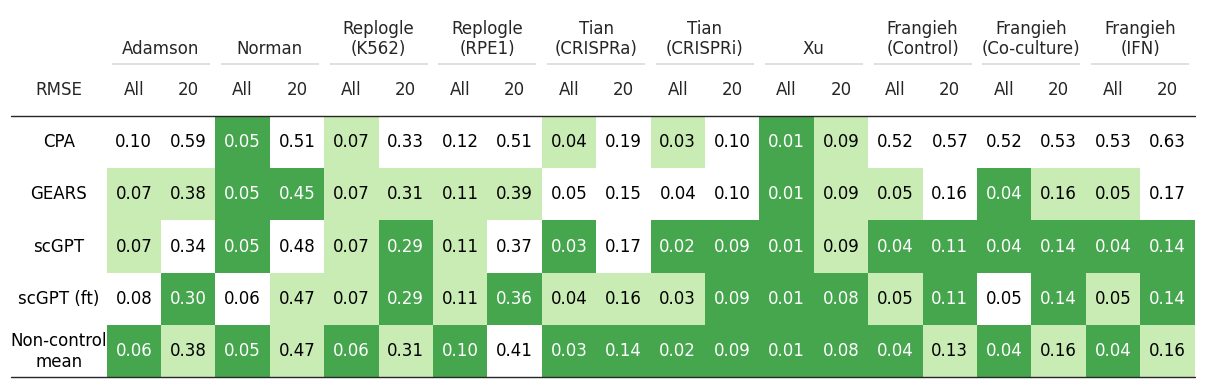

In [28]:
fontsize=12

method_names = {
    'cpa': 'CPA',
    'gears': 'GEARS',
    'scgpt': 'scGPT',
    'scgpt_ft': 'scGPT (ft)',
    'nonctl-mean': 'Non-control\nmean',
    # 'matching-mean': 'Matching mean'
}

metric_names = {
    'rmse_all': 'All',
    'rmse_20de': '20',
}

results_df_ = results_df[results_df['one gene'] == '1-gene']
results_df_['method'] = results_df_['method'].replace(method_names)
results_df_['dataset'] = results_df_['dataset'].map(dataset_map)
df = results_df_[['dataset', 'method'] + list(metric_names.keys())].groupby(['dataset', 'method']).mean()
df = df.round(2)
df_ = df.unstack(level=0).swaplevel(1, 0, axis=1).loc[method_names.values()]

col_defs = [
        ColumnDefinition(
            name="method",
            title="RMSE",
            textprops={"ha": "center", "fontsize": fontsize},  # "weight": "bold"
            width=1.75,
        ),
    ]

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

cols_order = []
for d in dataset_labels:
    for m, m_name in metric_names.items():
        cmap_name = matplotlib.cm.PiYG
        if '↓' in m_name:
            cmap_name = matplotlib.cm.PiYG_r
            print(m_name)
        
        col = (d, m)
        cols_order.append(col)
        col_def = ColumnDefinition(
            name=col,
            title=m_name,
            group=d,
            border="left",
            formatter="{:.2f}",
            width=1,
            textprops={
                "ha": "center",
            },
            cmap = custom_cmap(df_[(d, m)], descending=True)
        )
        col_defs.append(col_def)

fig, ax = plt.subplots(figsize=(12.25, 4))
table = Table(
    df_[cols_order],
    column_definitions=col_defs,
    row_dividers=False,
    col_label_divider=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": fontsize},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 0, "linestyle": "-"},
).autoset_fontcolors()  # colnames=["OFF", "DEF"]
plt.tight_layout()
plt.savefig(f'{figdir}/benchmark_summary_table_rmse_combined.pdf', bbox_inches='tight');
plt.show()

#### Dotplot figure, pert centroid

/tmp/ipykernel_2854999/469006111.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_['method'] = results_df_['method'].replace(method_names)
/tmp/ipykernel_2854999/469006111.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_['dataset'] = results_df_['dataset'].map(dataset_map)


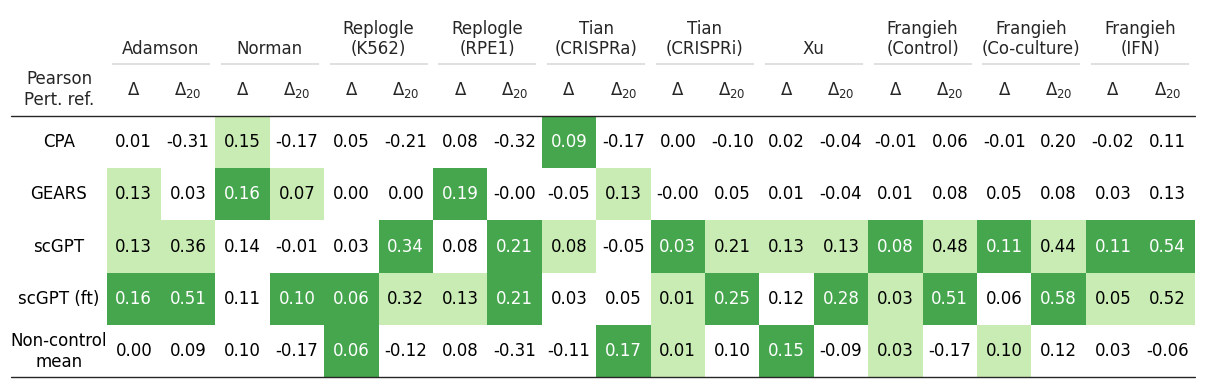

In [32]:
fontsize=12

method_names = {
    'cpa': 'CPA',
    'gears': 'GEARS',
    'scgpt': 'scGPT',
    'scgpt_ft': 'scGPT (ft)',
    'nonctl-mean': 'Non-control\nmean',
}

metric_names = {
    'corr_all_allpert': '$\Delta$',
    'corr_20de_allpert': '${\Delta_{20}}$',
}

results_df_ = results_df[results_df['one gene'] == '1-gene']
results_df_['method'] = results_df_['method'].replace(method_names)
results_df_['dataset'] = results_df_['dataset'].map(dataset_map)
df = results_df_[['dataset', 'method'] + list(metric_names.keys())].groupby(['dataset', 'method']).mean()
df = df.round(2)
df_ = df.unstack(level=0).swaplevel(1, 0, axis=1).loc[method_names.values()]

col_defs = [
        ColumnDefinition(
            name="method",
            title="Pearson\nPert. ref.",
            textprops={"ha": "center", "fontsize": fontsize},  # "weight": "bold"
            width=1.75,
        ),
    ]

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

cols_order = []
for d in dataset_labels:
    for m, m_name in metric_names.items():
        cmap_name = matplotlib.cm.PiYG
        if '↓' in m_name:
            cmap_name = matplotlib.cm.PiYG_r
            print(m_name)
        
        col = (d, m)
        cols_order.append(col)
        col_def = ColumnDefinition(
            name=col,
            title=m_name,
            # formatter=decimal_to_percent,
            group=d,
            border="left",
            formatter="{:.2f}",
            width=1,
            # cmap=cmap,
            textprops={
                "ha": "center",
                # "bbox": {"boxstyle": "circle", "pad": 0.},
            },
            cmap = custom_cmap(df_[(d, m)], descending=m_name.endswith('↓'))
            # cmap=normed_cmap(df_[col], cmap=cmap_name, num_stds=2),
        )
        col_defs.append(col_def)

fig, ax = plt.subplots(figsize=(12.25, 4))

# letter_annotation(plt.gca(), 0, 0.9, 'a', fontsize=28)
table = Table(
    df_[cols_order],
    column_definitions=col_defs,
    row_dividers=False,
    col_label_divider=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": fontsize},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 0, "linestyle": "-"},
).autoset_fontcolors()  # colnames=["OFF", "DEF"]
plt.tight_layout()
plt.savefig(f'{figdir}/benchmark_summary_table_pearson_allpert_combined.pdf', bbox_inches='tight');
plt.show()

In [ ]:
fontsize = 19
method_names = {
    'cpa': 'CPA',
    'gears': 'GEARS',
    'scgpt': 'scGPT',
    'scgpt_ft': 'scGPT (ft)',
    'nonctl-mean': 'Non control mean',
    'matching-mean': 'Matching mean'
}

metric_names = {
    'corr_all_allpert': 'Pearson↑',
    'corr_20de_allpert': 'Pearson$_{20}$↑',
    'rmse_all_allpert': 'RMSE↓',
    'rmse_20de_allpert': 'RMSE$_{20}$↓',
    'jaccard_allpert': 'Jaccard$_{20}$↑'
}

# datasets_ = ['ReplogleK562', 'Adamson2016', 'Norman2019']
dataset_names = {
    # 'ReplogleK562': 'ReplogleK562',
    'Adamson2016': 'Adamson',
    'Dixit2016': 'Dixit',
    'Norman2019': 'Norman'
}

results_df['method'] = results_df['method'].replace(method_names)
results_df['dataset'] = results_df['dataset'].replace(dataset_names)

df = results_df[['dataset', 'method'] + list(metric_names.keys())].groupby(['dataset', 'method']).mean()
df = df.round(2)
df_ = df.unstack(level=0).swaplevel(1, 0, axis=1).loc[method_names.values()]

col_defs = [
        ColumnDefinition(
            name="method",
            title="Method",
            textprops={"ha": "center", "fontsize": fontsize},  # "weight": "bold"
            width=1.75,
        ),
    ]

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

cols_order = []
for d in dataset_names.values():
    for m, m_name in metric_names.items():
        cmap_name = matplotlib.cm.PiYG
        if '↓' in m_name:
            cmap_name = matplotlib.cm.PiYG_r
            print(m_name)
            
        col = (d, m)
        cols_order.append(col)
        col_def = ColumnDefinition(
            name=col,
            title=m_name,
            # formatter=decimal_to_percent,
            group=d,
            border="left",
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.35},
            },
            formatter="{:.2f}",
            width=1,
            # cmap=cmap
            cmap=normed_cmap(df_[col], cmap=cmap_name, num_stds=2),
        )
        col_defs.append(col_def)

In [ ]:
fig, ax = plt.subplots(figsize=(24, 8))

# letter_annotation(plt.gca(), 0, 0.9, 'a', fontsize=28)
table = Table(
    df_[cols_order],
    column_definitions=col_defs,
    row_dividers=True,
    col_label_divider=False,
    footer_divider=False,
    # even_row_color='whitesmoke',
    ax=ax,
    textprops={"fontsize": fontsize},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 0, "linestyle": "-"},
).autoset_fontcolors()  # colnames=["OFF", "DEF"]
plt.tight_layout()
plt.savefig(f'{figdir}/benchmark_summary_table_allpert.pdf', bbox_inches='tight');
# plt.savefig(f'{figdir}/benchmark_summary_table_adamson_norman.pdf', bbox_inches='tight');

#### Norman results

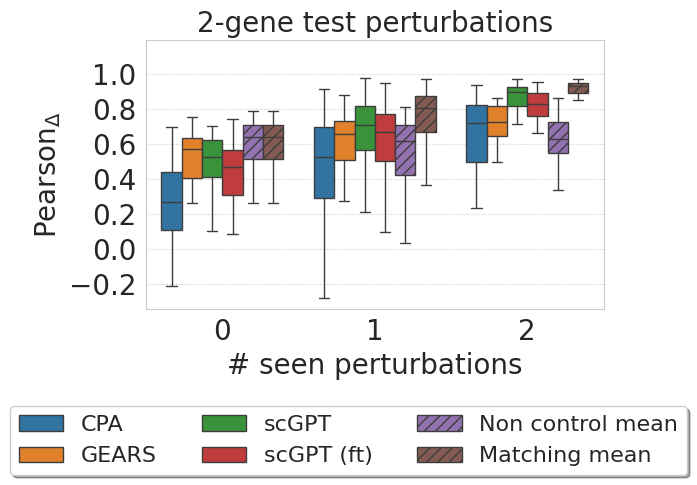

In [36]:
sns.set_style('whitegrid')
results_df_2 = results_df[results_df['dataset'] == 'Norman2019']

nrows = 1
ncols = 2
fontsize = 20
fliersize = 2
showfliers = False
fig = plt.figure(figsize=(6, 4))

ax = sns.boxplot(data=results_df_2[results_df_2['one gene'] == '2-gene'], x='train', y='corr_all', hue='method',
                                  order=['0', '1', '2'],
                                  fliersize=fliersize,
                                  showfliers=showfliers,
                                  hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson$_{\Delta}$', fontsize=fontsize) # , labelpad=-10)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0),
                    fancybox=True, shadow=True, ncol=3, fontsize=16)

labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
    
hatches = ["", "", "", "", "///", "///"]
for lp, hatch in zip(legend.get_patches(), hatches):
    lp.set_hatch(hatch)

plt.ylim((None, 1.19))
plt.tight_layout(w_pad=2)
plt.grid(axis='y', linestyle='dotted')
plt.show()

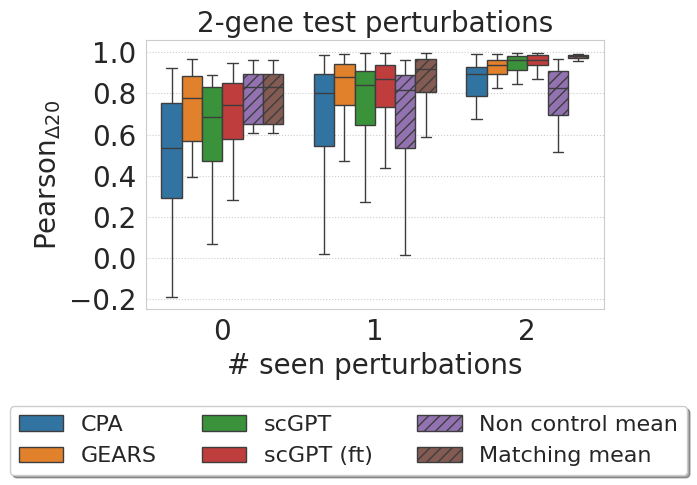

In [38]:
nrows = 1
ncols = 2
fontsize = 20
fliersize = 2
showfliers = False
fig = plt.figure(figsize=(6, 4))

ax = sns.boxplot(data=results_df_2[results_df_2['one gene'] == '2-gene'], x='train', y='corr_20de', hue='method',
                                  order=['0', '1', '2'],
                                  fliersize=fliersize,
                                  showfliers=showfliers,
                                  hue_order=methods)
patch.set_hatch(hatch)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson$_{\Delta20}$', fontsize=fontsize) # , labelpad=-10)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0),
                    fancybox=True, shadow=True, ncol=3, fontsize=16)

labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
    
hatches = ["", "", "", "", "///", "///"]
for lp, hatch in zip(legend.get_patches(), hatches):
    lp.set_hatch(hatch)

plt.tight_layout(w_pad=2)
plt.grid(axis='y', linestyle='dotted')
plt.show()

#### Download results

In [ ]:
import base64
import pandas as pd
from IPython.display import HTML

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [ ]:
create_download_link(results_df)